# LeNet模型

LeNet是一个早期用来识别手写数字的卷积神经网络，这个名字来源于LeNet论文的第一作者Yann LeCun。LeNet展示了通过梯度下降训练卷积神经网络可以达到手写数字识别在当时最先进的成果，这个尊基性的工作第一次将卷积神经网络推上舞台

<img src='./datasets/LeNet.jpg'>
上图就是LeNet模型，下面将对每层参数进行说明

## input输入层

假设输入层数据shape=(32,32)

## C1卷积层

- 卷积核大小: kernel_size=(5,5)
- 步幅:stride = 1
- 输出通道为6
- 可训练参数为: (5 * 5 + 1) * 6
- 激活函数：采用relu
输入层数据经过C1卷积层后将得到feature maps形状(6 * 28 * 28),注：28 = 32 -5 + 1

## S2池化层

池化层(Max Pooling)窗口形状均为2*2，步幅度为2，输出feature maps为(6 *14 * 14),6为feature map的数量

## C3卷积层

- 卷积核大小: kernel_size=(5,5)
- 步幅:stride = 1
- 输出通道为16
- 激活函数：采用relu得到feature maps为(16 * 10 * 10),(10*10)为每个feature map形状,16为feature map数量

## S4池化层

池化层(Max Pooling)窗口形状依然均为2*2，步幅度为2，输出feature maps为(16 *5 * 5),16为feature map的数量

## C5全链接层

- 输出120个神经元
- 激活函数：relu

## F6全连接层

- 输出84个神经元
- 激活函数：relu

## output

- 输出10个神经元
- 激活函数：无

# 用Mxnet实现LeNet模型

In [15]:
import mxnet as mx
from mxnet import autograd,init,nd
from mxnet.gluon import nn,Trainer
from mxnet.gluon import data as gdata
from mxnet.gluon import loss as gloss
import time

class LeNet_mxnet:
    def __init__(self):
        self.net = nn.Sequential()
        self.net.add(nn.Conv2D(channels=6,kernel_size=5,activation='relu'),
                nn.MaxPool2D(pool_size =(2,2),strides=(2,2)),
                nn.Conv2D(channels=16,kernel_size=(5,5),strides=(1,1),padding=(0,0),activation='relu'),
                nn.MaxPool2D(pool_size =(2,2),strides=(2,2)),
                nn.Dense(units=120,activation='relu'),
                nn.Dense(units=84,activation='relu'),
                nn.Dense(units=10)  #最后一个全连接层激活函数取决于损失函数
               )
        
    def train(self,train_iter,test_iter,n_epochs,ctx):
        print('training on',ctx)
        self.net.initialize(force_reinit=True,ctx=ctx,init=init.Xavier())
        trainer_op = Trainer(self.net.collect_params(),'adam',{'learning_rate':0.01})
        loss = gloss.SoftmaxCrossEntropyLoss()
        
        accuracy_val = 0
        for epoch in range(n_epochs):
            
            train_loss_sum,train_acc_sum,n,start = 0.0,0.0,0,time.time()
            
            for x_batch,y_batch in train_iter:
                x_batch,y_batch = x_batch.as_in_context(ctx),y_batch.as_in_context(ctx)
                with autograd.record():
                    y_hat = self.net(x_batch)
                    loss_val = loss(y_hat,y_batch).sum()
                loss_val.backward()
                trainer_op.step(n_batches)
                y_batch = y_batch.astype('float32')
                train_loss_sum += loss_val.asscalar()
                train_acc_sum += (y_hat.argmax(axis=1) == y_batch).sum().asscalar()
                n += y_batch.size
            test_acc = self.accuracy_score(test_iter,ctx)
            accuracy_val += self.accuracy_score(test_iter,ctx)
            print('epoch:%d,train_loss:%.4f,train_acc:%.3f,test_acc:%.3f,time:%.1f sec' 
                  %(epoch+1, train_loss_sum / n, train_acc_sum/ n,test_acc,time.time() - start))
    
    def accuracy_score(self,data_iter,ctx):
        acc_sum,n = nd.array([0],ctx=ctx),0
        for x,y in data_iter:
            x,y = x.as_in_context(ctx),y.as_in_context(ctx)
            y = y.astype('float32')
            acc_sum += (self.net(x).argmax(axis=1) == y).sum()
            n += y.size
        return acc_sum.asscalar() / n
    
    def __call__(self,x):
        return self.net(x)
    
    def predict(self,x,ctx):
        x = x.as_in_context(ctx)
        return self.net(x).argmax(axis=1)
    
    def print_info(self):
        print(self.net[4].params)

# 使用mnist手写数字数据集进行测试

In [4]:
from tensorflow.keras.datasets import mnist

(x_train,y_train),(x_test,y_test) = mnist.load_data()
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
x_train = x_train.reshape(60000,1,28,28).astype('float32')
x_test = x_test.reshape(10000,1,28,28).astype('float32')

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [16]:
lenet_mxnet = LeNet_mxnet()
epochs = 10
n_batches = 500
train_iter = gdata.DataLoader(gdata.ArrayDataset(x_train,y_train),batch_size=n_batches)
test_iter = gdata.DataLoader(gdata.ArrayDataset(x_test,y_test),batch_size=n_batches)
lenet_mxnet.train(train_iter,test_iter,epochs,ctx=mx.gpu())

training on gpu(0)
epoch:1,train_loss:1.8267,train_acc:0.571,test_acc:0.896,time:3.0 sec
epoch:2,train_loss:0.2449,train_acc:0.924,test_acc:0.948,time:2.6 sec
epoch:3,train_loss:0.1563,train_acc:0.952,test_acc:0.954,time:2.6 sec
epoch:4,train_loss:0.1302,train_acc:0.961,test_acc:0.962,time:2.5 sec
epoch:5,train_loss:0.1169,train_acc:0.964,test_acc:0.958,time:2.5 sec
epoch:6,train_loss:0.1017,train_acc:0.969,test_acc:0.967,time:2.5 sec
epoch:7,train_loss:0.0855,train_acc:0.973,test_acc:0.964,time:3.3 sec
epoch:8,train_loss:0.0848,train_acc:0.973,test_acc:0.964,time:3.6 sec
epoch:9,train_loss:0.0767,train_acc:0.976,test_acc:0.963,time:3.5 sec
epoch:10,train_loss:0.0771,train_acc:0.977,test_acc:0.970,time:3.5 sec


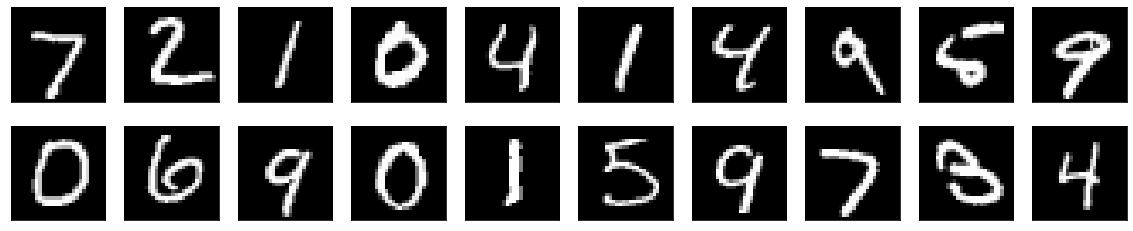

predict result: 
[7. 2. 1. 0. 4. 1. 4. 9. 5. 9. 0. 6. 9. 0. 1. 5. 9. 7. 3. 4.]
<NDArray 20 @gpu(0)>


In [17]:
# 将预测结果可视化
import matplotlib.pyplot as plt

def plt_image(image):
    n = 20
    plt.figure(figsize=(20,4))
    for i in range(n):
        ax = plt.subplot(2,10,i+1)
        plt.imshow(x_test[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
plt_image(x_test)
print('predict result:',lenet_mxnet.predict(nd.array(x_test[0:20]),ctx=mx.gpu()))


# 附：需要注意的知识点

- (1) 注意SoftmaxCrossEntropyLoss的使用，hybrid_forward源码说明，若from_logits为False时(默认为Flase),会先通过log_softmax计算各分类的概率，再计算loss,同样SigmoidBinaryCrossEntropyLoss也提供了from_sigmoid参数决定是否在hybrid_forward函数中要计算sigmoid函数,<b>所以在创建模型最后一层的时候要特别注意是否要给激活函数</b>

- (2) 注意权重初始化选择

- (3) 注意(y_hat.argmax(axis=1) == y_batch)操作时y_batch数据类型转换

- (4) 上面的模型没有对数据集进行归一化处理，可以添加该步骤